# RL Examples (Grid World)

This notebook provides a comparative tutorial on three different reinforcement learning approaches:
1. **Dynamic Programming (DP)** - Model-based methods that require full knowledge of the environment
2. **Representative RL** - Model-free methods like Q-learning and Deep Q-Networks (DQN)
3. **Monte Carlo Tree Search (MCTS)** - Simulation-based planning method

We'll implement and compare these methods on a common GridWorld environment for consistency.

## Setup and Dependencies

In [119]:
# Install required packages
%pip install gymnasium numpy matplotlib torch pygame

Note: you may need to restart the kernel to use updated packages.


In [120]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import copy
import math
from IPython.display import clear_output
from time import sleep

## Part 1: GridWorld Environment

We'll implement a simple GridWorld environment for testing all our algorithms.

In [121]:
class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.actions = ['up', 'right', 'down', 'left']
        self.action_indices = {action: i for i, action in enumerate(self.actions)}
        
        # Create a simple grid with a goal and some obstacles
        self.grid = np.zeros((size, size))
        # -1 is obstacle, 1 is goal, 0 is free space
        self.grid[1, 1] = -1  # Obstacle
        self.grid[1, 3] = -1  # Obstacle
        self.grid[3, 3] = -1  # Obstacle
        self.grid[4, 4] = 1   # Goal
        
        self.terminal_states = [(4, 4)]  # Goal location
        self.reset()
    
    def reset(self):
        # Start at the top-left corner
        self.agent_pos = (0, 0)
        self.done = False
        return self.agent_pos
    
    def step(self, action_idx):
        if self.done:
            return self.agent_pos, 0, True, {}
        
        # Get the action name from index
        action = self.actions[action_idx]
        
        # Current position
        row, col = self.agent_pos
        
        # Calculate new position based on action
        if action == 'up' and row > 0:
            row -= 1
        elif action == 'right' and col < self.size - 1:
            col += 1
        elif action == 'down' and row < self.size - 1:
            row += 1
        elif action == 'left' and col > 0:
            col -= 1
        
        # Check if new position is an obstacle
        if self.grid[row, col] == -1:
            # Stay in the same position if it's an obstacle
            row, col = self.agent_pos
        
        # Update agent position
        self.agent_pos = (row, col)
        
        # Calculate reward and done
        reward = -1  # Step penalty
        if self.agent_pos in self.terminal_states:
            reward = 10  # Goal reward
            self.done = True
        
        return self.agent_pos, reward, self.done, {}
    
    def render(self):
        grid_display = np.zeros((self.size, self.size), dtype=str)
        grid_display.fill('.')
        
        # Mark obstacles
        for i in range(self.size):
            for j in range(self.size):
                if self.grid[i, j] == -1:
                    grid_display[i, j] = '#'
                elif self.grid[i, j] == 1:
                    grid_display[i, j] = 'G'
        
        # Mark agent position
        row, col = self.agent_pos
        grid_display[row, col] = 'A'
        
        # Display the grid
        print('\n'.join([' '.join(row) for row in grid_display]))
    
    def get_all_states(self):
        states = []
        for i in range(self.size):
            for j in range(self.size):
                if self.grid[i, j] != -1:  # If not an obstacle
                    states.append((i, j))
        return states
    
    def get_transition_prob(self, state, action):
        # For deterministic environment, returns the next state with prob 1.0
        row, col = state
        next_row, next_col = row, col
        
        if action == 0 and row > 0:  # Up
            next_row = row - 1
        elif action == 1 and col < self.size - 1:  # Right
            next_col = col + 1
        elif action == 2 and row < self.size - 1:  # Down
            next_row = row + 1
        elif action == 3 and col > 0:  # Left
            next_col = col - 1
        
        # Check if next state is an obstacle
        if self.grid[next_row, next_col] == -1:
            next_row, next_col = row, col  # Stay in the same position
        
        next_state = (next_row, next_col)
        reward = -1  # Step penalty
        
        if next_state in self.terminal_states:
            reward = 10  # Goal reward
        
        # Return format: [(next_state, reward, done, prob)]
        return [(next_state, reward, next_state in self.terminal_states, 1.0)]
    
    # Add observation_space and action_space properties for DQN compatibility
    @property
    def observation_space(self):
        # Return a simple Box space for the state (row, col)
        class SimpleSpace:
            def __init__(self, shape):
                self.shape = shape
        return SimpleSpace((2,))
    
    @property
    def action_space(self):
        # Return a simple Discrete space for actions
        class SimpleSpace:
            def __init__(self, n):
                self.n = n
        return SimpleSpace(len(self.actions))

# Create a single instance of the environment to be used by all algorithms
env = GridWorld()
print("Initial GridWorld state:")
env.render()

Initial GridWorld state:
A . . . .
. # . # .
. . . . .
. . . # .
. . . . G


## Part 2: Dynamic Programming (DP)

Let's implement Value Iteration and Policy Iteration methods using our GridWorld.

Running Dynamic Programming algorithms...
Value Iteration converged after 9 iterations
Policy Iteration converged after 6 iterations
Value Iteration Results:


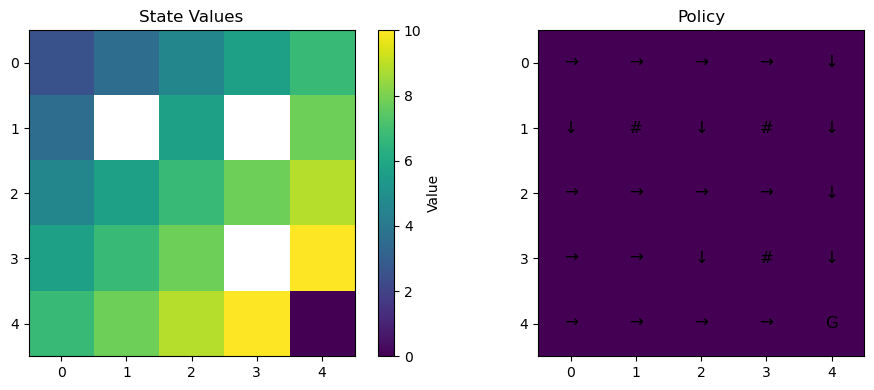

Policy Iteration Results:


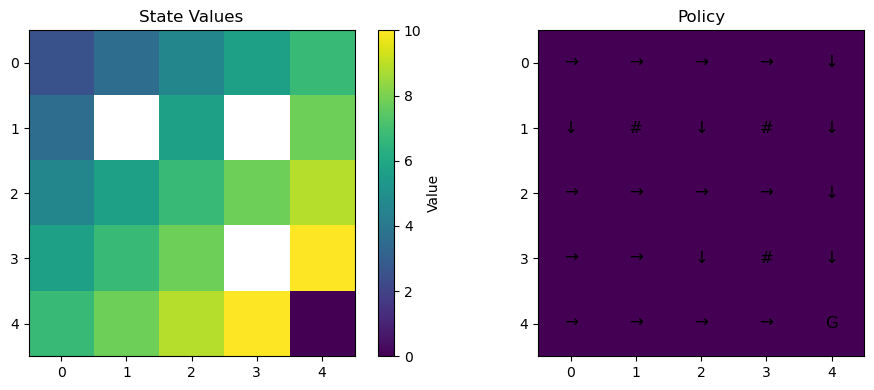

In [122]:
def value_iteration(env, gamma=0.99, theta=1e-8):
    # Initialize value function
    states = env.get_all_states()
    V = {state: 0 for state in states}
    
    # Value iteration
    iteration = 0
    while True:
        delta = 0
        for state in states:
            if state in env.terminal_states:
                continue
                
            old_value = V[state]
            
            # Compute the value for all possible actions from this state
            action_values = []
            for action in range(len(env.actions)):
                transitions = env.get_transition_prob(state, action)
                value = 0
                for next_state, reward, done, prob in transitions:
                    value += prob * (reward + gamma * V[next_state] * (not done))
                action_values.append(value)
            
            # Update the state value with the maximum value
            V[state] = max(action_values)
            
            # Track the maximum change in value
            delta = max(delta, abs(old_value - V[state]))
        
        iteration += 1
        if delta < theta:
            break
    
    print(f"Value Iteration converged after {iteration} iterations")
    
    # Extract policy from value function
    policy = {}
    for state in states:
        if state in env.terminal_states:
            policy[state] = None
            continue
            
        action_values = []
        for action in range(len(env.actions)):
            transitions = env.get_transition_prob(state, action)
            value = 0
            for next_state, reward, done, prob in transitions:
                value += prob * (reward + gamma * V[next_state] * (not done))
            action_values.append(value)
        
        policy[state] = np.argmax(action_values)
    
    return V, policy

def policy_iteration(env, gamma=0.99, theta=1e-8):
    # Initialize random policy
    states = env.get_all_states()
    policy = {state: random.randint(0, len(env.actions) - 1) 
              for state in states if state not in env.terminal_states}
    for state in env.terminal_states:
        policy[state] = None
    
    # Initialize value function
    V = {state: 0 for state in states}
    
    policy_stable = False
    policy_iteration = 0
    
    while not policy_stable:
        # Policy Evaluation
        while True:
            delta = 0
            for state in states:
                if state in env.terminal_states:
                    continue
                    
                old_value = V[state]
                action = policy[state]
                
                # Compute new state value based on the policy
                transitions = env.get_transition_prob(state, action)
                V[state] = 0
                for next_state, reward, done, prob in transitions:
                    V[state] += prob * (reward + gamma * V[next_state] * (not done))
                    
                delta = max(delta, abs(old_value - V[state]))
            
            if delta < theta:
                break
        
        # Policy Improvement
        policy_stable = True
        for state in states:
            if state in env.terminal_states:
                continue
                
            old_action = policy[state]
            
            # Compute the value for all possible actions
            action_values = []
            for action in range(len(env.actions)):
                transitions = env.get_transition_prob(state, action)
                value = 0
                for next_state, reward, done, prob in transitions:
                    value += prob * (reward + gamma * V[next_state] * (not done))
                action_values.append(value)
            
            # Update policy to choose the best action
            policy[state] = np.argmax(action_values)
            
            if old_action != policy[state]:
                policy_stable = False
        
        policy_iteration += 1
        if policy_stable:
            break
    
    print(f"Policy Iteration converged after {policy_iteration} iterations")
    return V, policy

# Run dynamic programming algorithms using the same environment instance
print("Running Dynamic Programming algorithms...")
vi_values, vi_policy = value_iteration(env)
pi_values, pi_policy = policy_iteration(env)

# Display results
def display_values_and_policy(env, values, policy):
    # Display values
    value_grid = np.zeros((env.size, env.size))
    for i in range(env.size):
        for j in range(env.size):
            if (i, j) in values:
                value_grid[i, j] = values[(i, j)]
            else:
                value_grid[i, j] = float('-inf')  # For obstacles
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(value_grid, cmap='viridis')
    plt.colorbar(label='Value')
    plt.title('State Values')
    
    # Display policy
    policy_grid = np.zeros((env.size, env.size), dtype=object)
    arrows = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    
    for i in range(env.size):
        for j in range(env.size):
            if (i, j) in policy and policy[(i, j)] is not None:
                policy_grid[i, j] = arrows[policy[(i, j)]]
            elif env.grid[i, j] == -1:
                policy_grid[i, j] = '#'  # Obstacle
            elif (i, j) in env.terminal_states:
                policy_grid[i, j] = 'G'  # Goal
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.zeros((env.size, env.size)), cmap='viridis')
    for i in range(env.size):
        for j in range(env.size):
            plt.text(j, i, policy_grid[i, j], ha='center', va='center', fontsize=12)
    plt.title('Policy')
    plt.tight_layout()
    plt.show()

print("Value Iteration Results:")
display_values_and_policy(env, vi_values, vi_policy)

print("Policy Iteration Results:")
display_values_and_policy(env, pi_values, pi_policy)

## Part 3: Representative RL - Q-Learning

Let's implement classic Q-learning for our grid world.

Running Q-Learning algorithm...
Episode 0, Step 0
A . . . .
. # . # .
. . . . .
. . . # .
. . . . G
Episode 0, Step 1
A . . . .
. # . # .
. . . . .
. . . # .
. . . . G
Episode 0, Step 2
. A . . .
. # . # .
. . . . .
. . . # .
. . . . G
Episode 0, Step 3
. A . . .
. # . # .
. . . . .
. . . # .
. . . . G
Episode 0, Step 4
. . A . .
. # . # .
. . . . .
. . . # .
. . . . G
Episode 0, Step 5
. . A . .
. # . # .
. . . . .
. . . # .
. . . . G
Episode 0, Step 6
. . . A .
. # . # .
. . . . .
. . . # .
. . . . G
Episode 0, Step 7
. . . A .
. # . # .
. . . . .
. . . # .
. . . . G
Episode 0, Step 8
. . . . A
. # . # .
. . . . .
. . . # .
. . . . G
Episode 0, Step 9
. . . . A
. # . # .
. . . . .
. . . # .
. . . . G
Episode 0, Step 10
. . . . A
. # . # .
. . . . .
. . . # .
. . . . G
Episode 0, Step 11
. . . . .
. # . # A
. . . . .
. . . # .
. . . . G
Episode 0, Step 12
. . . . A
. # . # .
. . . . .
. . . # .
. . . . G
Episode 0, Step 13
. . . A .
. # . # .
. . . . .
. . . # .
. . . . G
Episode 0, S

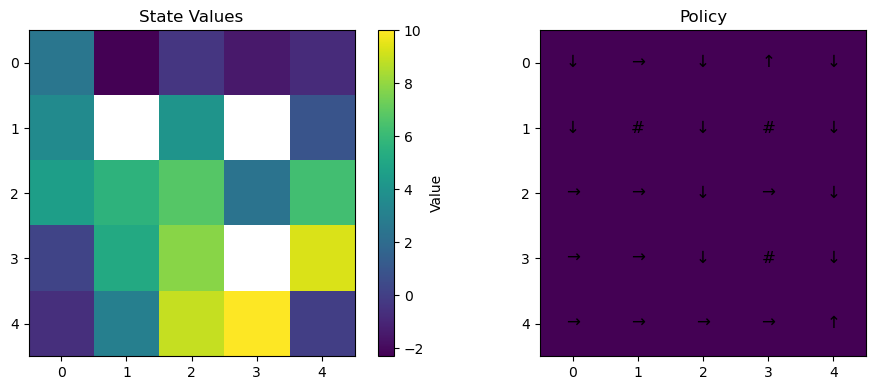

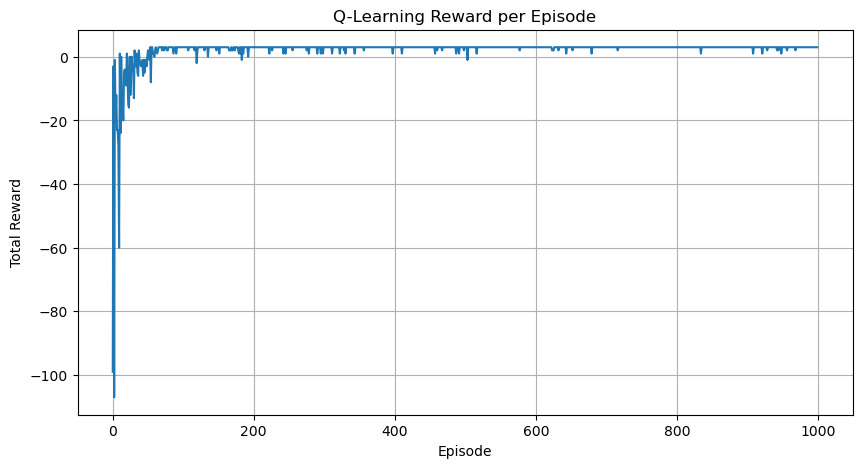

In [123]:
def q_learning(env, episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1):
    # Reset the environment to ensure we start fresh
    env.reset()
    
    # Initialize Q-table
    q_table = {}
    states = env.get_all_states()
    for state in states:
        q_table[state] = np.zeros(len(env.actions))
    
    # Metrics to track
    rewards_per_episode = []
    steps_per_episode = []
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0
        
        while not done:
            # Only render occasionally to speed up training
            if episode % 100 == 0:
                print(f"Episode {episode}, Step {steps}")
                env.render()
                
            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = random.randint(0, len(env.actions) - 1)  # Explore
            else:
                action = np.argmax(q_table[state])  # Exploit
            
            # Take the action
            next_state, reward, done, _ = env.step(action)
            
            # Q-learning update
            best_next_action = np.argmax(q_table[next_state])
            td_target = reward + gamma * q_table[next_state][best_next_action] * (not done)
            td_error = td_target - q_table[state][action]
            q_table[state][action] += alpha * td_error
            
            # Update state
            state = next_state
            total_reward += reward
            steps += 1
        
        rewards_per_episode.append(total_reward)
        steps_per_episode.append(steps)
        
        # Decay epsilon
        epsilon = max(0.01, epsilon * 0.995)
        
        # Print progress periodically
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(rewards_per_episode[-100:])
            avg_steps = np.mean(steps_per_episode[-100:])
            print(f"Episode {episode + 1}/{episodes}, Avg Reward: {avg_reward:.2f}, Avg Steps: {avg_steps:.2f}")
    
    # Extract policy from Q-table
    policy = {state: np.argmax(q_table[state]) for state in states}
    
    # Calculate state values from Q-values
    values = {state: np.max(q_table[state]) for state in states}
    
    return q_table, policy, values, rewards_per_episode

# Run Q-learning with the same environment
print("Running Q-Learning algorithm...")
q_table, q_policy, q_values, q_rewards = q_learning(env, episodes=1000)

# Plot learning curve
def plot_learning_curve(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title('Q-Learning Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()

# Display results
print("Q-Learning Results:")
display_values_and_policy(env, q_values, q_policy)
plot_learning_curve(q_rewards)

## Part 4: Deep Q-Network (DQN)

Let's implement DQN for our GridWorld environment (adapted from CartPole).

Running Deep Q-Network algorithm...
DQN Episode 0, Step 0
A . . . .
. # . # .
. . . . .
. . . # .
. . . . G
DQN Episode 0, Step 1
. . . . .
A # . # .
. . . . .
. . . # .
. . . . G
DQN Episode 0, Step 2
. . . . .
A # . # .
. . . . .
. . . # .
. . . . G
DQN Episode 0, Step 3
. . . . .
A # . # .
. . . . .
. . . # .
. . . . G
DQN Episode 0, Step 4
A . . . .
. # . # .
. . . . .
. . . # .
. . . . G
DQN Episode 0, Step 5
A . . . .
. # . # .
. . . . .
. . . # .
. . . . G
DQN Episode 0, Step 6
A . . . .
. # . # .
. . . . .
. . . # .
. . . . G
DQN Episode 0, Step 7
. A . . .
. # . # .
. . . . .
. . . # .
. . . . G
DQN Episode 0, Step 8
. A . . .
. # . # .
. . . . .
. . . # .
. . . . G
DQN Episode 0, Step 9
. . A . .
. # . # .
. . . . .
. . . # .
. . . . G
DQN Episode 0, Step 10
. . . . .
. # A # .
. . . . .
. . . # .
. . . . G
DQN Episode 0, Step 11
. . . . .
. # . # .
. . A . .
. . . # .
. . . . G
DQN Episode 0, Step 12
. . . . .
. # . # .
. . . A .
. . . # .
. . . . G
DQN Episode 0, Step 13
. 

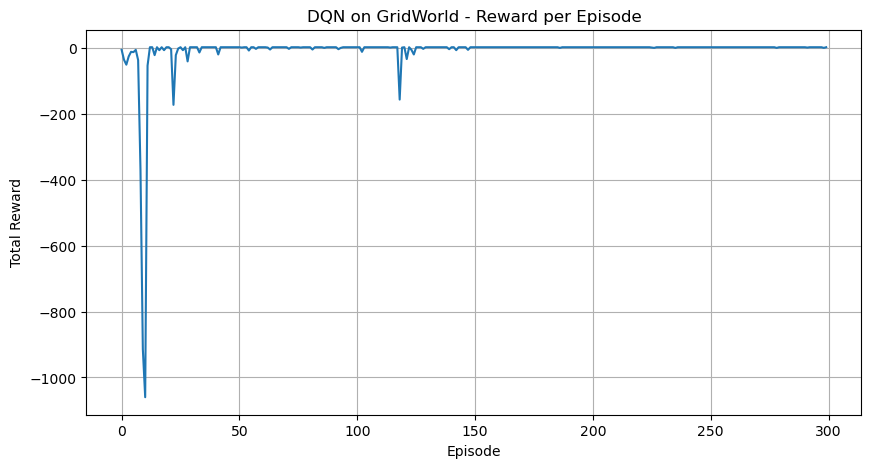

DQN Results:


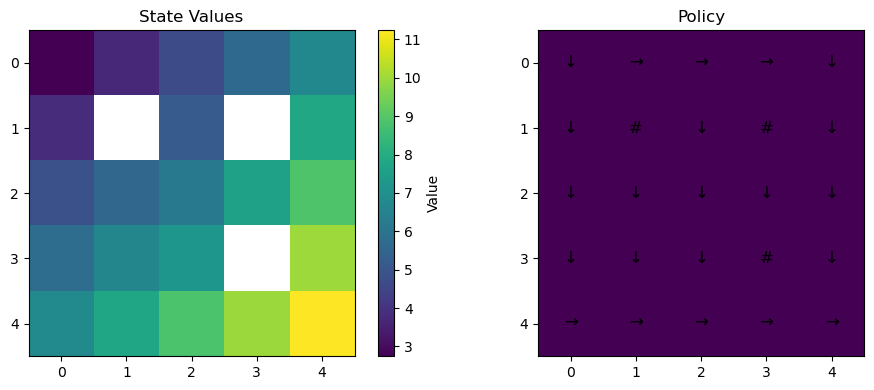

In [124]:
# State converter for GridWorld to feed into DQN
def state_to_tensor(state):
    # Convert GridWorld state tuple to a tensor
    # Normalize coordinates to [0,1] range
    row, col = state
    size = env.size
    return torch.FloatTensor([row/size, col/size])

# DQN Network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Replay Memory
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Experience(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

# DQN Agent for GridWorld
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size=64, gamma=0.99, lr=0.001, epsilon_start=1.0):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayMemory(10000)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.995
        
        # Networks
        self.policy_net = DQN(state_size, action_size)
        self.target_net = DQN(state_size, action_size)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
    
    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)
        else:
            with torch.no_grad():
                state_tensor = state_to_tensor(state)
                q_values = self.policy_net(state_tensor)
                return q_values.max(0)[1].item()
    
    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        
        experiences = self.memory.sample(self.batch_size)
        batch = Experience(*zip(*experiences))
        
        # Convert to tensors - handle GridWorld states
        state_batch = torch.stack([state_to_tensor(s) for s in batch.state])
        action_batch = torch.LongTensor(batch.action).unsqueeze(1)
        reward_batch = torch.FloatTensor(batch.reward)
        next_state_batch = torch.stack([state_to_tensor(s) for s in batch.next_state])
        done_batch = torch.FloatTensor(batch.done)
        
        # Compute current Q values
        current_q_values = self.policy_net(state_batch).gather(1, action_batch)
        
        # Compute target Q values
        with torch.no_grad():
            next_q_values = self.target_net(next_state_batch).max(1)[0]
        
        # Compute expected Q values
        expected_q_values = reward_batch + (self.gamma * next_q_values * (1 - done_batch))
        
        # Compute loss
        loss = F.mse_loss(current_q_values.squeeze(), expected_q_values)
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
        
        return loss.item()
    
    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Train DQN on GridWorld
def train_dqn(env, episodes=300):
    # Reset the environment to ensure we start fresh
    env.reset()
    
    # State size is 2 for GridWorld (row, col)
    state_size = 2  # Normalized row and column
    action_size = len(env.actions)
    agent = DQNAgent(state_size, action_size)
    
    rewards = []
    values_history = []  # To track values of states over time
    
    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        steps = 0
        
        while not done:
            # Only render occasionally to speed up training
            if episode % 50 == 0:
                print(f"DQN Episode {episode}, Step {steps}")
                env.render()
                
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            
            # Store experience
            agent.memory.push(state, action, next_state, reward, float(done))
            
            # Learn
            loss = agent.learn()
            
            state = next_state
            episode_reward += reward
            steps += 1
        
        # Update target network periodically
        if episode % 10 == 0:
            agent.update_target_network()
        
        rewards.append(episode_reward)
        
        if (episode + 1) % 20 == 0:
            avg_reward = np.mean(rewards[-20:])
            print(f"Episode {episode+1}/{episodes}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
    
    # Extract policy and values from the trained network
    dqn_policy = {}
    dqn_values = {}
    states = env.get_all_states()
    
    for state in states:
        with torch.no_grad():
            state_tensor = state_to_tensor(state)
            q_values = agent.policy_net(state_tensor).numpy()
            dqn_policy[state] = np.argmax(q_values)
            dqn_values[state] = np.max(q_values)
    
    return agent, rewards, dqn_policy, dqn_values

# Train DQN with the same GridWorld environment
print("Running Deep Q-Network algorithm...")
dqn_agent, dqn_rewards, dqn_policy, dqn_values = train_dqn(env, episodes=300)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dqn_rewards)
plt.title('DQN on GridWorld - Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

# Display DQN policy and values
print("DQN Results:")
display_values_and_policy(env, dqn_values, dqn_policy)

## Part 5: Monte Carlo Tree Search (MCTS)

Implementing MCTS for the GridWorld environment.

Running Monte Carlo Tree Search algorithm...
Episode 1, Step 1, State: (0, 0)
A . . . .
. # . # .
. . . . .
. . . # .
. . . . G
Action 0: Visits=177, Value=-60.847
Action 1: Visits=1, Value=-100.000
Action 2: Visits=1, Value=-100.000
Action 3: Visits=21, Value=-75.714
MCTS chooses action: up
Episode 1, Step 2, State: (0, 0)
A . . . .
. # . # .
. . . . .
. . . # .
. . . . G
Action 0: Visits=5, Value=-78.400
Action 1: Visits=169, Value=-62.320
Action 2: Visits=22, Value=-74.409
Action 3: Visits=4, Value=-77.500
MCTS chooses action: right
Episode 1, Step 3, State: (0, 1)
. A . . .
. # . # .
. . . . .
. . . # .
. . . . G
Action 0: Visits=1, Value=-100.000
Action 1: Visits=1, Value=-100.000
Action 2: Visits=1, Value=-100.000
Action 3: Visits=197, Value=-18.563
MCTS chooses action: left
Episode 1, Step 4, State: (0, 0)
A . . . .
. # . # .
. . . . .
. . . # .
. . . . G
Action 0: Visits=1, Value=-100.000
Action 1: Visits=3, Value=-78.000
Action 2: Visits=195, Value=-64.995
Action 3: Visits=1, 

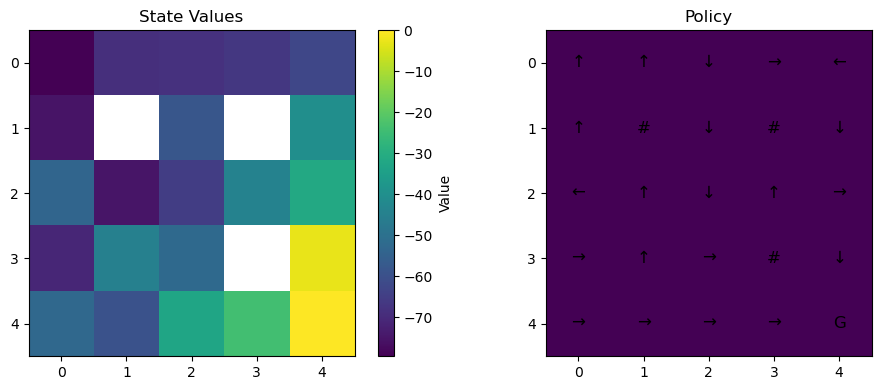

In [125]:
class MCTSNode:
    def __init__(self, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action  # Action that led to this state from parent
        self.children = {}  # Maps actions to nodes
        self.visits = 0
        self.value = 0.0
        self.untried_actions = list(range(4))  # Four actions: up, right, down, left
    
    def is_fully_expanded(self):
        return len(self.untried_actions) == 0
    
    def best_child(self, c_param=1.4):
        # UCB1 formula for selection
        weights = [
            (child.value / child.visits) + c_param * math.sqrt(2 * math.log(self.visits) / child.visits)
            for action, child in self.children.items()
        ]
        return list(self.children.keys())[np.argmax(weights)]
    
    def expand(self, action, next_state):
        child = MCTSNode(next_state, parent=self, action=action)
        self.untried_actions.remove(action)
        self.children[action] = child
        return child
    
    def update(self, result):
        self.visits += 1
        self.value += result

# MCTS Algorithm
class MCTS:
    def __init__(self, env, exploration_weight=1.4):
        self.env = env
        self.exploration_weight = exploration_weight
    
    def choose_action(self, state, simulations=1000):
        root = MCTSNode(state)
        
        for _ in range(simulations):
            # Make a copy of the environment
            sim_env = copy.deepcopy(self.env)
            sim_env.agent_pos = root.state  # Set state
            sim_env.done = False
            
            # Run one iteration of MCTS
            node = self.select(root)
            reward = self.simulate(sim_env, node.state)
            self.backpropagate(node, reward)
        
        # Choose action with highest average value
        return self.best_action(root)
    
    def select(self, node):
        # Selection phase - Traverse tree until we reach a leaf node
        while not node.state in self.env.terminal_states and node.is_fully_expanded():
            action = node.best_child(self.exploration_weight)
            node = node.children[action]
        
        # Expansion phase - If leaf node is not terminal and has untried actions
        if not node.state in self.env.terminal_states and not node.is_fully_expanded():
            # Choose a random untried action
            action = random.choice(node.untried_actions)
            
            # Set up simulation environment
            sim_env = copy.deepcopy(self.env)
            sim_env.agent_pos = node.state
            sim_env.done = False
            
            # Take the action
            next_state, _, _, _ = sim_env.step(action)
            
            # Add child node
            node = node.expand(action, next_state)
        
        return node
    
    def simulate(self, env, state):
        # Simulation phase - Play out the game randomly from this state
        env.agent_pos = state
        env.done = False
        
        if state in env.terminal_states:
            return 10  # Goal reward
        
        total_reward = 0
        max_steps = 100  # Prevent infinite loops
        steps = 0
        
        while not env.done and steps < max_steps:
            action = random.randint(0, 3)  # Random policy
            _, reward, done, _ = env.step(action)
            total_reward += reward
            steps += 1
            
            if done:
                break
        
        return total_reward
    
    def backpropagate(self, node, reward):
        # Backpropagation phase - Update statistics up the tree
        while node is not None:
            node.update(reward)
            node = node.parent
    
    def best_action(self, node):
        # Choose action with highest average value
        visits = {action: child.visits for action, child in node.children.items()}
        values = {action: child.value / child.visits if child.visits > 0 else 0
                 for action, child in node.children.items()}
        
        # Print statistics for debugging
        for action in range(4):
            if action in visits:
                print(f"Action {action}: Visits={visits[action]}, Value={values[action]:.3f}")
        
        # Return action with highest value
        return max(values.items(), key=lambda x: x[1])[0]

# Extract MCTS policy by running it on each state
def extract_mcts_policy(env, mcts, states):
    mcts_policy = {}
    mcts_values = {}
    
    for state in states:
        if state in env.terminal_states:
            mcts_policy[state] = None
            mcts_values[state] = 0
            continue
            
        # Run MCTS from this state with fewer simulations for efficiency
        action = mcts.choose_action(state, simulations=100)
        mcts_policy[state] = action
        
        # Estimate state value by running simulations
        sim_rewards = []
        for _ in range(10):  # Run 10 simulations to estimate value
            sim_env = copy.deepcopy(env)
            sim_env.agent_pos = state
            sim_env.done = False
            reward = mcts.simulate(sim_env, state)
            sim_rewards.append(reward)
        mcts_values[state] = np.mean(sim_rewards)
    
    return mcts_policy, mcts_values

# Test MCTS on GridWorld
def run_mcts(env, episodes=5):
    # Reset the environment to ensure we start fresh
    env.reset()
    
    mcts = MCTS(env)
    total_rewards = []
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0
        
        while not done:
            print(f"Episode {episode+1}, Step {steps+1}, State: {state}")
            env.render()
            
            # Choose action using MCTS
            action = mcts.choose_action(state, simulations=200)  # Reduced simulations for speed
            print(f"MCTS chooses action: {env.actions[action]}")
            
            # Take the action
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state
            steps += 1
            
            if done:
                print(f"Episode finished after {steps} steps with reward {total_reward}")
                env.render()
                break
        
        total_rewards.append(total_reward)
        print(f"Episode {episode+1}/{episodes} completed with total reward: {total_reward}")
    
    # Extract MCTS policy and values
    states = env.get_all_states()
    mcts_policy, mcts_values = extract_mcts_policy(env, mcts, states)
    
    return mcts, total_rewards, mcts_policy, mcts_values

# Run MCTS with the same GridWorld environment
print("Running Monte Carlo Tree Search algorithm...")
mcts_agent, mcts_rewards, mcts_policy, mcts_values = run_mcts(env, episodes=5)

# Display MCTS results
print("MCTS Results:")
display_values_and_policy(env, mcts_values, mcts_policy)

## Part 6: Comparative Analysis

Let's compare the performance of all four methods on the same GridWorld environment.

Efficiency Analysis:
Method	|	Requires Model	|	Sample Efficiency	|	Computational Complexity
--------------------------------------------------------------------------------
DP	|	Yes		|	N/A (Model-based)	|	O(|S|²|A|) per iteration
Q-Learning	|	No		|	Low to Medium		|	O(|A|) per step
DQN	|	No		|	Very Low		|	O(|A| + NN size) per step
MCTS	|	Partial		|	Medium			|	O(simulations × sim_depth) per step
Comparing policies from different methods:
State	|	DP	|	Q-Learning	|	DQN	|	MCTS	|	Agreement
--------------------------------------------------------------------------------
(0, 0)	|	right	|	down	|	down	|	up	|	Disagree
(0, 1)	|	right	|	right	|	right	|	up	|	Disagree
(0, 2)	|	right	|	down	|	right	|	down	|	Disagree
(0, 3)	|	right	|	up	|	right	|	right	|	Disagree
(0, 4)	|	down	|	down	|	down	|	left	|	Disagree
(1, 0)	|	down	|	down	|	down	|	up	|	Disagree
(1, 2)	|	down	|	down	|	down	|	down	|	All agree
(1, 4)	|	down	|	down	|	down	|	down	|	All agree
(2, 0)	|	right	|	right	|	down	|	left	|	Disagree
(2, 1)	|	ri

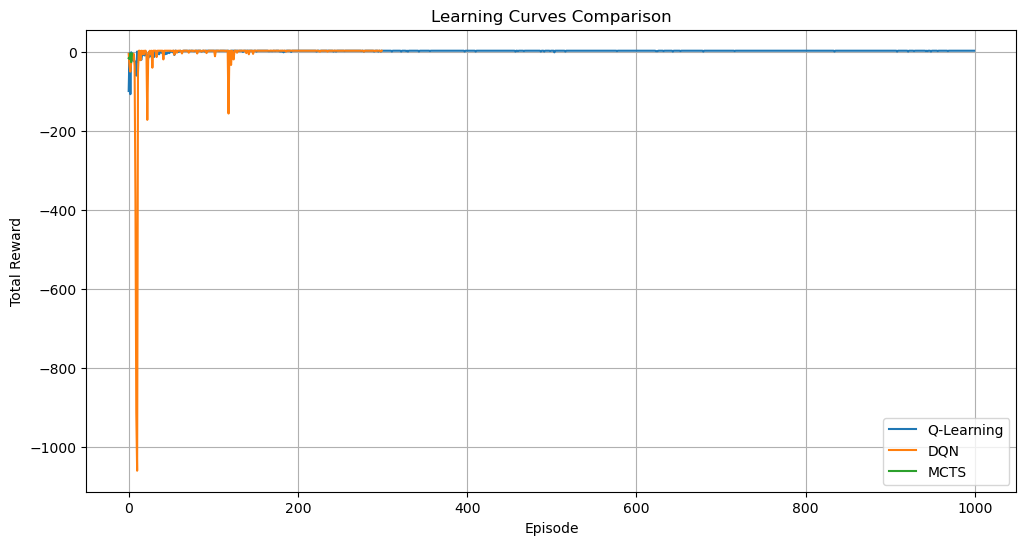


Summary of Methods on the Same GridWorld Environment:

Dynamic Programming (DP):
+ Guarantees optimal solution
+ Very sample efficient (no samples needed)
- Requires complete model of the environment
- Suffers from curse of dimensionality
- Not suitable for large state spaces

Q-Learning:
+ Model-free, learns from experience
+ Simple to implement
+ Converges to optimal policy with sufficient exploration
- Requires extensive exploration in large state spaces
- Struggles with continuous state spaces without function approximation

Deep Q-Network (DQN):
+ Can handle large and continuous state spaces
+ Model-free, learns from experience
+ Can generalize across similar states
- Sample inefficient, requires many training samples
- Complex to implement and tune
- Can be unstable during training

Monte Carlo Tree Search (MCTS):
+ Works well with partial models
+ Can handle large branching factors
+ Naturally balances exploration and exploitation
- Computationally expensive at runtime
- Perfor

In [126]:
# Compare the policies obtained by each method
def compare_policies(env, dp_policy, q_policy, dqn_policy, mcts_policy):
    print("Comparing policies from different methods:")
    print("State\t|\tDP\t|\tQ-Learning\t|\tDQN\t|\tMCTS\t|\tAgreement")
    print("-" * 80)
    
    for state in dp_policy.keys():
        if state in env.terminal_states:
            continue
            
        dp_action = dp_policy[state]
        q_action = q_policy[state]
        dqn_action = dqn_policy[state]
        mcts_action = mcts_policy[state] if state in mcts_policy else None
        
        # Check if all algorithms agree on the action
        actions = [dp_action, q_action, dqn_action, mcts_action]
        valid_actions = [a for a in actions if a is not None]
        agreement = "All agree" if len(set(valid_actions)) == 1 else "Disagree"
        
        print(f"{state}\t|\t{env.actions[dp_action]}\t|\t{env.actions[q_action]}\t|\t{env.actions[dqn_action]}\t|\t{env.actions[mcts_action] if mcts_action is not None else 'N/A'}\t|\t{agreement}")

# Analyze the time and sample efficiency of each method
print("Efficiency Analysis:")
print("Method\t|\tRequires Model\t|\tSample Efficiency\t|\tComputational Complexity")
print("-" * 80)
print("DP\t|\tYes\t\t|\tN/A (Model-based)\t|\tO(|S|²|A|) per iteration")
print("Q-Learning\t|\tNo\t\t|\tLow to Medium\t\t|\tO(|A|) per step")
print("DQN\t|\tNo\t\t|\tVery Low\t\t|\tO(|A| + NN size) per step")
print("MCTS\t|\tPartial\t\t|\tMedium\t\t\t|\tO(simulations × sim_depth) per step")

# Compare all the policies
compare_policies(env, vi_policy, q_policy, dqn_policy, mcts_policy)

# Compare learning curves where applicable
plt.figure(figsize=(12, 6))
plt.plot(q_rewards, label='Q-Learning')
plt.plot(dqn_rewards, label='DQN')
if len(mcts_rewards) > 1:  # Only if we have enough data points
    plt.plot(mcts_rewards, label='MCTS')
plt.title('Learning Curves Comparison')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

# Summarize advantages and disadvantages
print("\nSummary of Methods on the Same GridWorld Environment:")
print("\nDynamic Programming (DP):")
print("+ Guarantees optimal solution")
print("+ Very sample efficient (no samples needed)")
print("- Requires complete model of the environment")
print("- Suffers from curse of dimensionality")
print("- Not suitable for large state spaces")

print("\nQ-Learning:")
print("+ Model-free, learns from experience")
print("+ Simple to implement")
print("+ Converges to optimal policy with sufficient exploration")
print("- Requires extensive exploration in large state spaces")
print("- Struggles with continuous state spaces without function approximation")

print("\nDeep Q-Network (DQN):")
print("+ Can handle large and continuous state spaces")
print("+ Model-free, learns from experience")
print("+ Can generalize across similar states")
print("- Sample inefficient, requires many training samples")
print("- Complex to implement and tune")
print("- Can be unstable during training")

print("\nMonte Carlo Tree Search (MCTS):")
print("+ Works well with partial models")
print("+ Can handle large branching factors")
print("+ Naturally balances exploration and exploitation")
print("- Computationally expensive at runtime")
print("- Performance depends on simulation quality")
print("- Less efficient for problems with long horizons")

print("\nConclusion:")
print("All four algorithms have their strengths and weaknesses. In our GridWorld environment:")
print("- DP found the optimal solution with complete model knowledge")
print("- Q-learning converged to a good policy with exploration")
print("- DQN shows how neural networks can be applied to RL problems")
print("- MCTS demonstrates planning-based approach with simulations")
print("This comparison highlights how different RL approaches tackle the same problem with different assumptions and capabilities.")